In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.model_selection import train_test_split

Dataset original de https://www.kaggle.com/datasets/marlesson/myanimelist-dataset-animes-profiles-reviews

In [2]:
animes = pd.read_csv("data/animes.csv")
animes.head()

,uid,title,synopsis,genre,aired,episodes,members,popularity,ranked,score,img_url,link
0,28891,Haikyuu!! Second Season,Following their participation at the Inter-Hig...,"['Comedy', 'Sports', 'Drama', 'School', 'Shoun...","Oct 4, 2015 to Mar 27, 2016",25.0,489888,141,25.0,8.82,https://cdn.myanimelist.net/images/anime/9/766...,https://myanimelist.net/anime/28891/Haikyuu_Se...
1,23273,Shigatsu wa Kimi no Uso,Music accompanies the path of the human metron...,"['Drama', 'Music', 'Romance', 'School', 'Shoun...","Oct 10, 2014 to Mar 20, 2015",22.0,995473,28,24.0,8.83,https://cdn.myanimelist.net/images/anime/3/671...,https://myanimelist.net/anime/23273/Shigatsu_w...
2,34599,Made in Abyss,The Abyss—a gaping chasm stretching down into ...,"['Sci-Fi', 'Adventure', 'Mystery', 'Drama', 'F...","Jul 7, 2017 to Sep 29, 2017",13.0,581663,98,23.0,8.83,https://cdn.myanimelist.net/images/anime/6/867...,https://myanimelist.net/anime/34599/Made_in_Abyss
3,5114,Fullmetal Alchemist: Brotherhood,"""In order for something to be obtained, someth...","['Action', 'Military', 'Adventure', 'Comedy', ...","Apr 5, 2009 to Jul 4, 2010",64.0,1615084,4,1.0,9.23,https://cdn.myanimelist.net/images/anime/1223/...,https://myanimelist.net/anime/5114/Fullmetal_A...
4,31758,Kizumonogatari III: Reiketsu-hen,After helping revive the legendary vampire Kis...,"['Action', 'Mystery', 'Supernatural', 'Vampire']","Jan 6, 2017",1.0,214621,502,22.0,8.83,https://cdn.myanimelist.net/images/anime/3/815...,https://myanimelist.net/anime/31758/Kizumonoga...


In [3]:
profiles = pd.read_csv("data/profiles.csv")
profiles.head()

,profile,gender,birthday,favorites_anime,link
0,DesolatePsyche,Male,"Oct 2, 1994","['33352', '25013', '5530', '33674', '1482', '2...",https://myanimelist.net/profile/DesolatePsyche
1,baekbeans,Female,"Nov 10, 2000","['11061', '31964', '853', '20583', '918', '925...",https://myanimelist.net/profile/baekbeans
2,skrn,NaN,NaN,"['918', '2904', '11741', '17074', '23273', '32...",https://myanimelist.net/profile/skrn
3,edgewalker00,Male,Sep 5,"['5680', '849', '2904', '3588', '37349']",https://myanimelist.net/profile/edgewalker00
4,aManOfCulture99,Male,"Oct 30, 1999","['4181', '7791', '9617', '5680', '2167', '4382...",https://myanimelist.net/profile/aManOfCulture99


In [4]:
reviews = pd.read_csv("data/reviews.csv")

# Assign a unique id to each username
unique_users = reviews["username"].unique()
user_mapping = {user: i for i, user in enumerate(unique_users)}
reviews["user_id"] = reviews["username"].map(user_mapping)
profiles["user_id"] = profiles["profile"].map(user_mapping)

# Assign anime uid from animes df (join on reviews.anime = animes.title)
anime_ids = animes[['title', 'uid']].copy()
reviews = pd.merge(reviews, anime_ids,
                   left_on='anime',
                   right_on='title',
                   how='left')
reviews = reviews.drop(columns=['title'])
reviews = reviews.rename(columns={'uid': 'item_id', 'score': 'rating'})

reviews.head()

,username,anime,rating,text,user_id,item_id
0,baekbeans,Juuni Taisen,7,While people may prize the unpredictability of...,0,35076.0
1,baekbeans,No Game No Life: Zero,8,If you watch no game no life zero with high ex...,0,33674.0
2,baekbeans,No Game No Life: Zero,8,If you watch no game no life zero with high ex...,0,33674.0
3,baekbeans,Made in Abyss,10,Let me start off by saying that Made in Abyss ...,0,34599.0
4,baekbeans,Made in Abyss,10,Let me start off by saying that Made in Abyss ...,0,34599.0


# Análisis de datos

Quitar nacimiento que no tiene año

In [5]:
profiles["birthday_year"] = profiles["birthday"].apply(lambda x: x[-4:] if pd.notna(x) else None)
profiles = profiles[profiles["birthday_year"].apply(lambda x: len(x) == 4 and x.isdigit() if pd.notna(x) else True)]
print(profiles["birthday_year"].value_counts())

birthday_year
1997    3405
1996    3317
1995    3294
1994    3140
1998    2899
        ... 
2021       2
1946       2
1951       2
1941       1
1953       1
Name: count, Length: 89, dtype: int64


In [6]:
reviews_with_more_than_one = reviews.groupby("user_id").filter(lambda x: len(x) > 1)
reviews_with_more_than_one = reviews_with_more_than_one.dropna(subset=['item_id'])
train_file, validation_file = train_test_split(reviews_with_more_than_one, test_size=0.2, random_state=42)
validation_file = validation_file[validation_file["user_id"].isin(train_file["user_id"])] # Ensure all users in validation are also in train

In [7]:
def get_stats(df):
    users_quantity = df["user_id"].nunique()
    items_quantity = df["item_id"].nunique()

    total_ratings = len(df)
    avg_ratings_per_user = total_ratings / users_quantity
    avg_ratings_per_item = total_ratings / items_quantity

    avg_rating = df["rating"].mean()
    std_rating = df["rating"].std()
    highest_number_of_ratings_by_user = df.groupby("user_id").size().max()
    highest_number_of_ratings_for_item = df.groupby("item_id").size().max()

    density = (total_ratings / (users_quantity * items_quantity)) * 100

    return {
        "Número de usuarios": users_quantity,
        "Número de animes": items_quantity,
        "Total de ratings": total_ratings,
        "Media de ratings por usuario": avg_ratings_per_user,
        "Media de ratings por anime": avg_ratings_per_item,
        "Rating media": avg_rating,
        "Desviación estándar de ratings": std_rating,
        "Mayor número de ratings por un usuario": highest_number_of_ratings_by_user,
        "Mayor número de ratings para un anime": highest_number_of_ratings_for_item,
        "Densidad (%)": f"{density}%"
    }

train_stats = get_stats(train_file)
val_stats = get_stats(validation_file)

rows = []
for key in train_stats.keys():
    rows.append([key, train_stats[key], val_stats[key]])

print(tabulate(rows, headers=["Estadística", "Training", "Validation"], tablefmt="grid"))


+----------------------------------------+----------------------+----------------------+
| Estadística                            | Training             | Validation           |
+========================================+======================+======================+
| Número de usuarios                     | 28196                | 15089                |
+----------------------------------------+----------------------+----------------------+
| Número de animes                       | 7156                 | 4488                 |
+----------------------------------------+----------------------+----------------------+
| Total de ratings                       | 139568               | 33653                |
+----------------------------------------+----------------------+----------------------+
| Media de ratings por usuario           | 4.949921974748191    | 2.230300218702366    |
+----------------------------------------+----------------------+----------------------+
| Media de ratings po

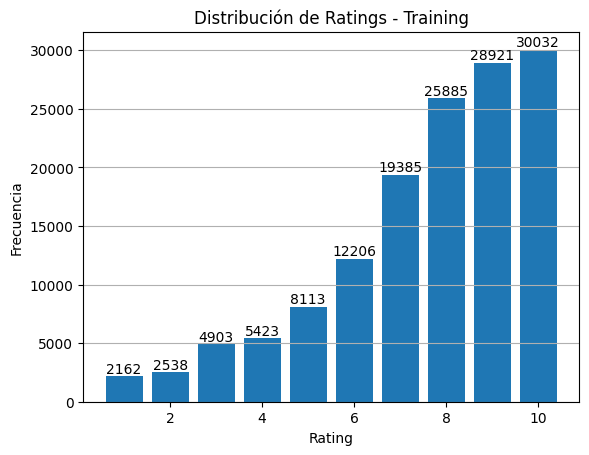

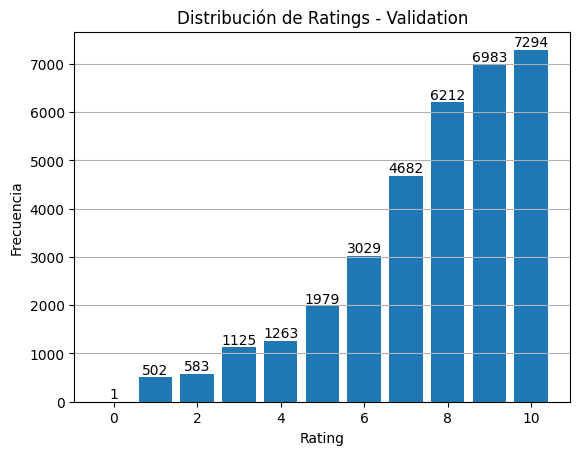

In [8]:
def plot_rating_distribution(ratings, title):
    counts = ratings.value_counts()
    bars = plt.bar(counts.index, counts.values)
    for bar, count in zip(bars, counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                 str(count), ha='center', va='bottom')

    plt.title(title)
    plt.xlabel("Rating")
    plt.ylabel("Frecuencia")
    plt.grid(axis='y')
    plt.show()

plot_rating_distribution(train_file["rating"], "Distribución de Ratings - Training")
plot_rating_distribution(validation_file["rating"], "Distribución de Ratings - Validation")

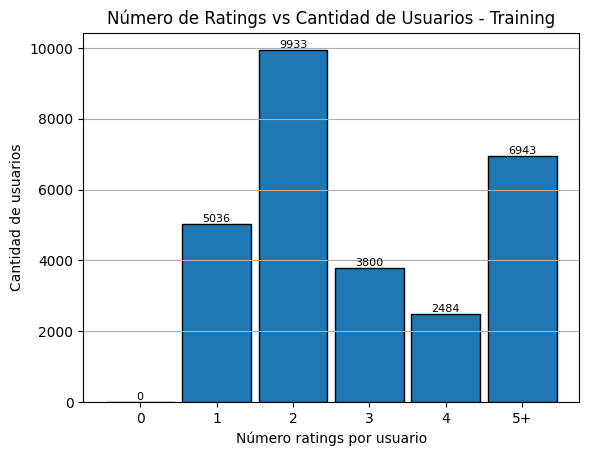

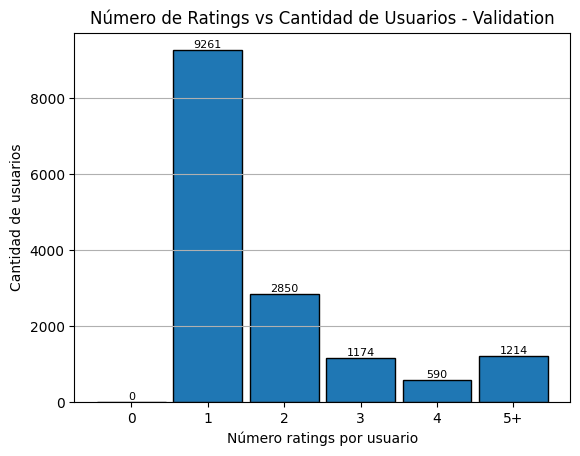

In [9]:
MAX_RATINGS = 5

def plot_ratings_per_user_distribution(df, title):
    ratings_per_user = df.groupby("user_id").size()
    clipped = ratings_per_user.clip(upper=MAX_RATINGS)
    counts = clipped.value_counts().reindex(range(0, MAX_RATINGS+1), fill_value=0)
    counts.index = [str(i) if i < MAX_RATINGS else f"{MAX_RATINGS}+" for i in range(0, MAX_RATINGS+1)]

    bars = plt.bar(counts.index, counts.values, width=0.9, edgecolor="black")
    for bar, count in zip(bars, counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                 str(count), ha="center", va="bottom", fontsize=8)

    plt.title(title)
    plt.xlabel("Número ratings por usuario")
    plt.ylabel("Cantidad de usuarios")
    plt.grid(axis="y")
    plt.show()


plot_ratings_per_user_distribution(train_file, "Número de Ratings vs Cantidad de Usuarios - Training")
plot_ratings_per_user_distribution(validation_file, "Número de Ratings vs Cantidad de Usuarios - Validation")


### Analísis de genero y edad

In [10]:
profiles["gender"].value_counts()

gender
Male          33418
Female        13279
Non-Binary      636
Name: count, dtype: int64

In [11]:
profiles["birthday_year"] = profiles["birthday_year"].apply(lambda x: int(x) if pd.notna(x) else None)
profiles["edad"] = profiles["birthday_year"].apply(lambda x: 2025 - x if pd.notna(x) else None)
profiles["edad"].value_counts().sort_index()

edad
4.0       2
5.0      41
6.0      20
7.0      29
8.0      17
       ... 
91.0      2
92.0      7
93.0      9
94.0     11
95.0    278
Name: count, Length: 89, dtype: int64

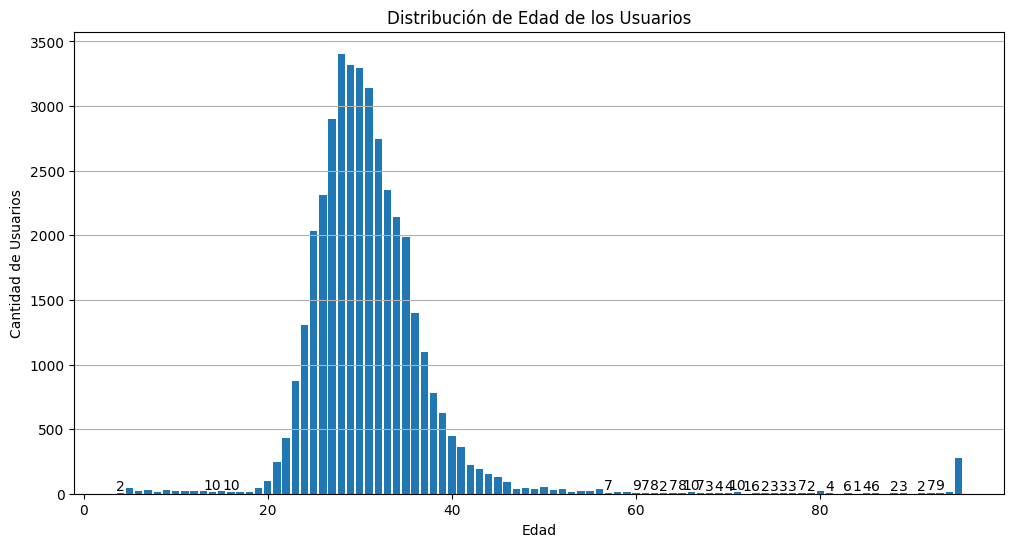

In [12]:
age_counts = profiles["edad"].value_counts().sort_index()

plt.figure(figsize=(12, 6))
bars = plt.bar(age_counts.index, age_counts.values)
plt.xlabel("Edad")
plt.ylabel("Cantidad de Usuarios")
plt.title("Distribución de Edad de los Usuarios")
plt.grid(axis='y')

for bar in bars:
    height = bar.get_height()
    if height <= 10:
        plt.text(bar.get_x() + bar.get_width() / 2., height,
                 '%d' % int(height),
                 ha='center', va='bottom')

plt.show()

In [13]:
train_file[['user_id', 'item_id', 'rating']].to_csv("train", index=False, header=False)
validation_file[['user_id', 'item_id', 'rating']].to_csv("test", index=False, header=False)

In [14]:
# 1. Handle "Not available" by treating it as NaN explicitly first (optional, but cleaner)
animes['aired'] = animes['aired'].replace('Not available', np.nan)

# 2. Extract Year 
# Any string that doesn't have 4 digits (like NaN) becomes NaN here
animes['release_year'] = animes['aired'].astype(str).str.extract(r'(\d{4})').astype(float)

# 3. Calculate Median Year (Compute this ONLY on train set to avoid data leakage)
median_year = animes['release_year'].median()
print(f"Imputing missing years with: {median_year}")

# 4. Fill missing years
animes['release_year'] = animes['release_year'].fillna(median_year)

# 5. Handle the 'is_ongoing' flag for these rows
# If 'aired' is NaN, contains('?') returns NaN. Fill those with 0 (False).
animes['is_ongoing'] = animes['aired'].astype(str).str.contains('\?').fillna(0).astype(int)

Imputing missing years with: 2009.0


In [15]:
from pathlib import Path
import os

dest = Path("clean_data")
os.makedirs(dest, exist_ok=True)

# Save all dataframes to clean_data folder
animes.to_csv(dest / "animes.csv", index=False)
profiles.to_csv(dest / "profiles.csv", index=False)
reviews.to_csv(dest / "reviews.csv", index=False)